### Clasificación utilizando LightGBM (LGBM)
- Parte 1: Carga y Exploración Inicial de Datos
  - Carga del Dataset: Cargar el dataset.
  - Exploración Inicial: Revisar la estructura del dataset. Describir las variables y su distribución. Identificar y documentar valores faltantes y outliers.


In [38]:
# para no mostrar mensajes en consola de los warnings
import warnings
warnings.filterwarnings('ignore')
# Import inicial, exploracion e imputacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Entrenamiento, evaluacion
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Cargar el dataset y hacer un resumen
df = pd.read_csv("../data/train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [11]:
# Verificar el contendio del dataset
print("DESCRIBE:\n", df.describe().T)
print("SHAPE:\n", df.shape)
print("INFO:\n", df.info())
print("DTYPES:\n", df.dtypes)
print("CANTIDAD NULOS:\n", df.isnull().sum())
print("CANTIDAD DUPLICADOS:", df.duplicated().sum())

DESCRIBE:
                    count         mean          std    min     25%     50%  \
ApplicantIncome    614.0  5403.459283  6109.041673  150.0  2877.5  3812.5   
CoapplicantIncome  614.0  1621.245798  2926.248369    0.0     0.0  1188.5   
LoanAmount         592.0   146.412162    85.587325    9.0   100.0   128.0   
Loan_Amount_Term   600.0   342.000000    65.120410   12.0   360.0   360.0   
Credit_History     564.0     0.842199     0.364878    0.0     1.0     1.0   

                       75%      max  
ApplicantIncome    5795.00  81000.0  
CoapplicantIncome  2297.25  41667.0  
LoanAmount          168.00    700.0  
Loan_Amount_Term    360.00    480.0  
Credit_History        1.00      1.0  
SHAPE:
 (614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non

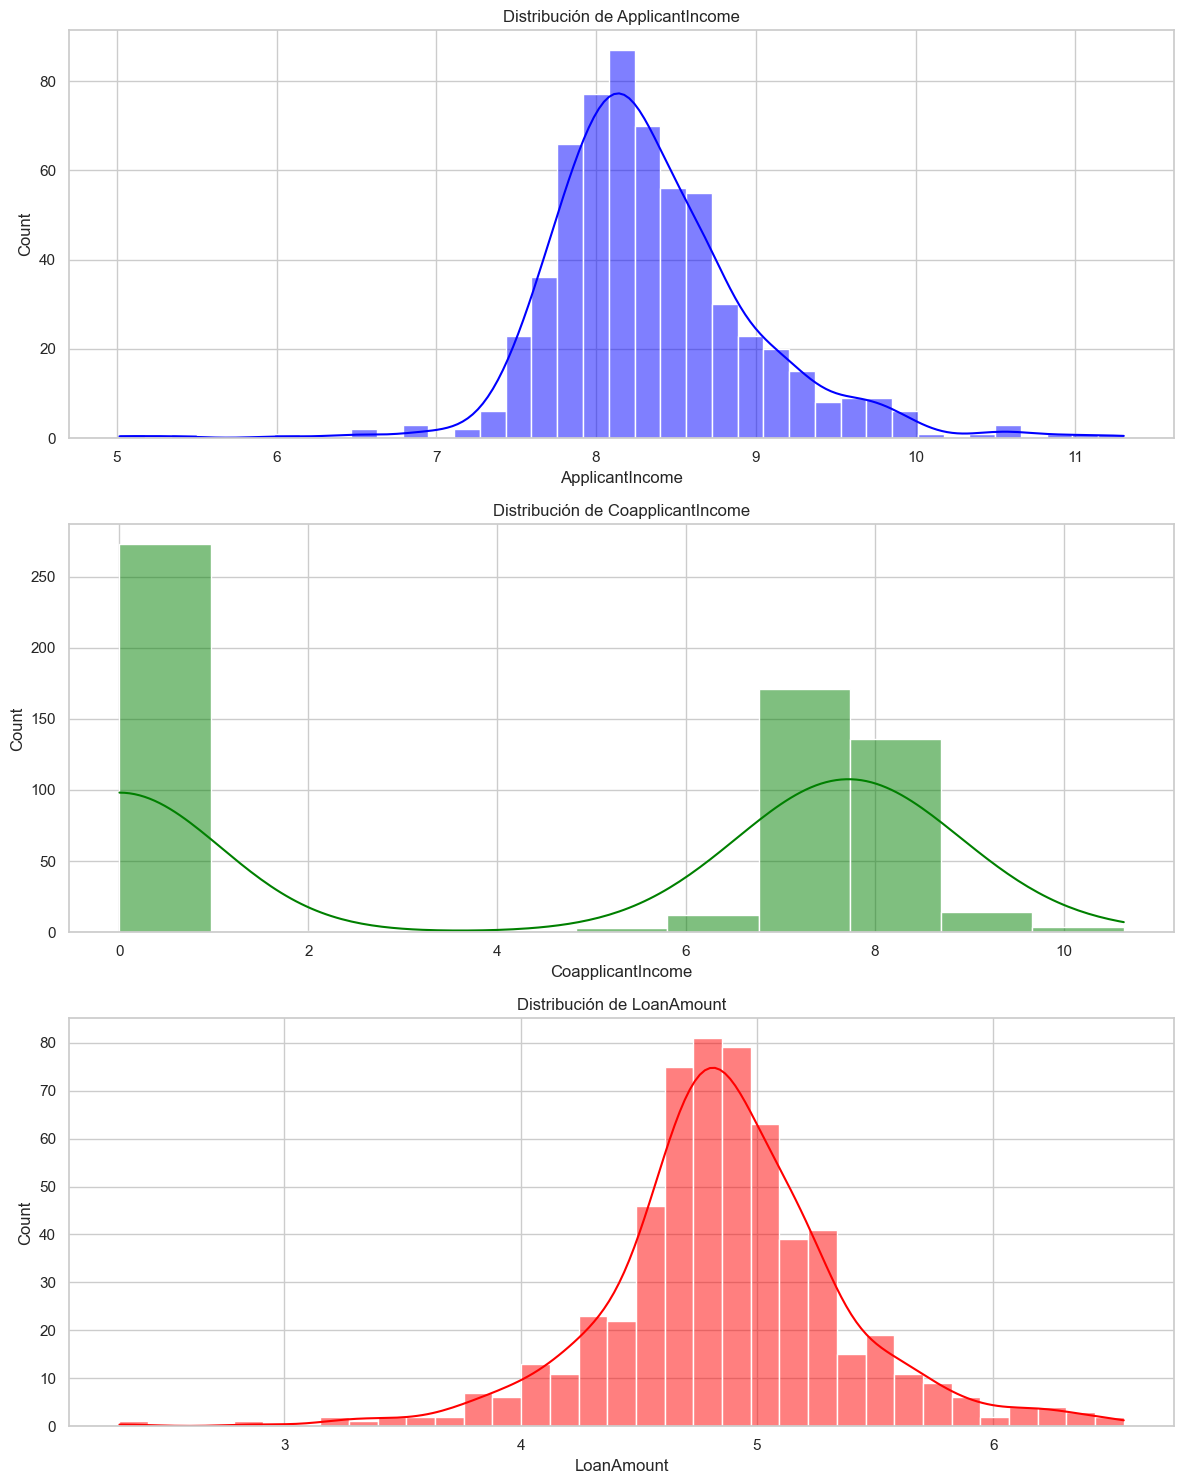

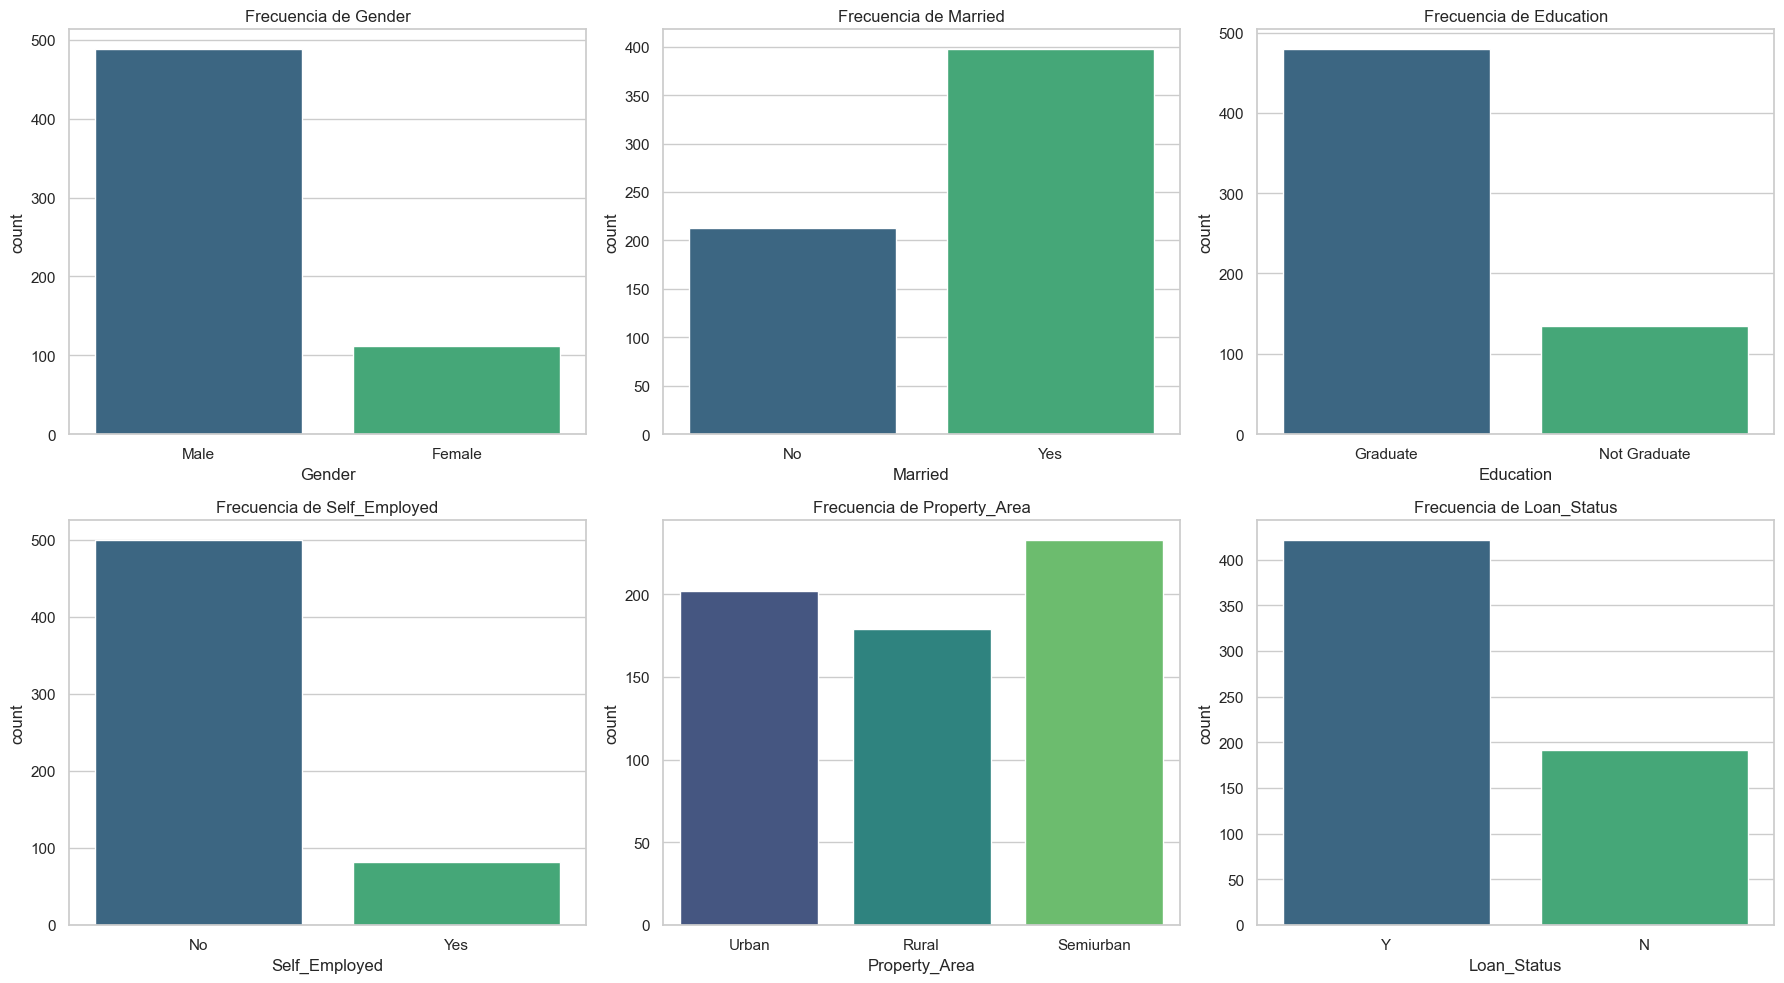

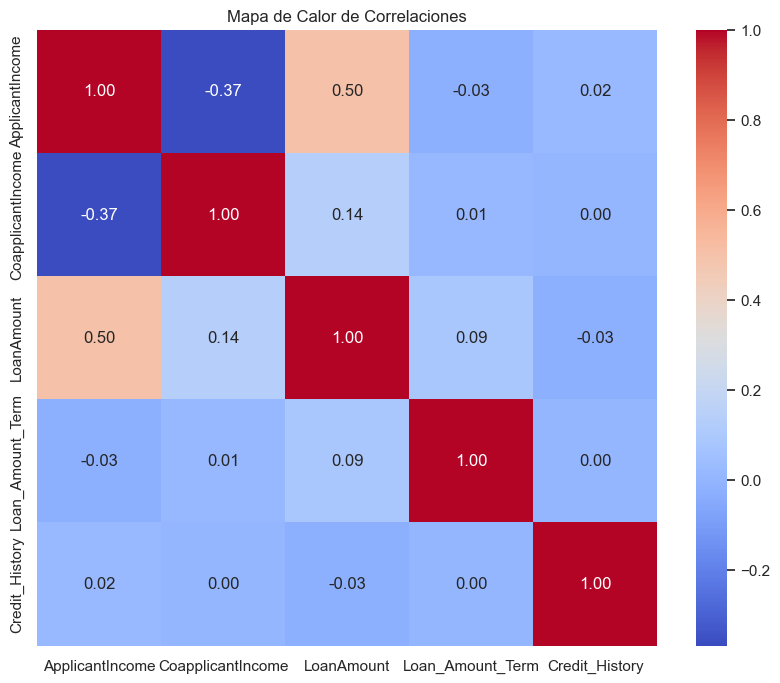

In [41]:
# Configuración de estilo para gráficos
sns.set(style="whitegrid")

# Gráficos de distribución de variables numéricas
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
sns.histplot(df['ApplicantIncome'], kde=True, ax=axes[0], color='blue').set_title("Distribución de ApplicantIncome")
sns.histplot(df['CoapplicantIncome'], kde=True, ax=axes[1], color='green').set_title("Distribución de CoapplicantIncome")
sns.histplot(df['LoanAmount'], kde=True, ax=axes[2], color='red').set_title("Distribución de LoanAmount")

plt.tight_layout()
plt.show()

# Gráfico de barras para variables categóricas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i // 3, i % 3], palette="viridis").set_title(f"Frecuencia de {col}")

plt.tight_layout()
plt.show()

# Mapa de calor para correlaciones
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f").set_title("Mapa de Calor de Correlaciones")
plt.show()

In [ ]:
# Estrategia: Rellenar valores categóricos con el modo y numéricos con la mediana
categorical_cols_with_nan = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']
numerical_cols_with_nan = ['LoanAmount']

# Rellenar valores faltantes
for col in categorical_cols_with_nan:
    df[col].fillna(df[col].mode()[0], inplace=True)

for col in numerical_cols_with_nan:
    df[col].fillna(df[col].median(), inplace=True)

# Confirmar que no queden valores faltantes
missing_after_fill = df.isnull().sum()

# Detección de outliers usando el rango intercuartil (IQR)
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
outliers = {}

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

missing_after_fill, {col: len(outliers[col]) for col in numerical_cols}

(Loan_ID              0
 Gender               0
 Married              0
 Dependents           0
 Education            0
 Self_Employed        0
 ApplicantIncome      0
 CoapplicantIncome    0
 LoanAmount           0
 Loan_Amount_Term     0
 Credit_History       0
 Property_Area        0
 Loan_Status          0
 dtype: int64,
 {'ApplicantIncome': 50, 'CoapplicantIncome': 18, 'LoanAmount': 41})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

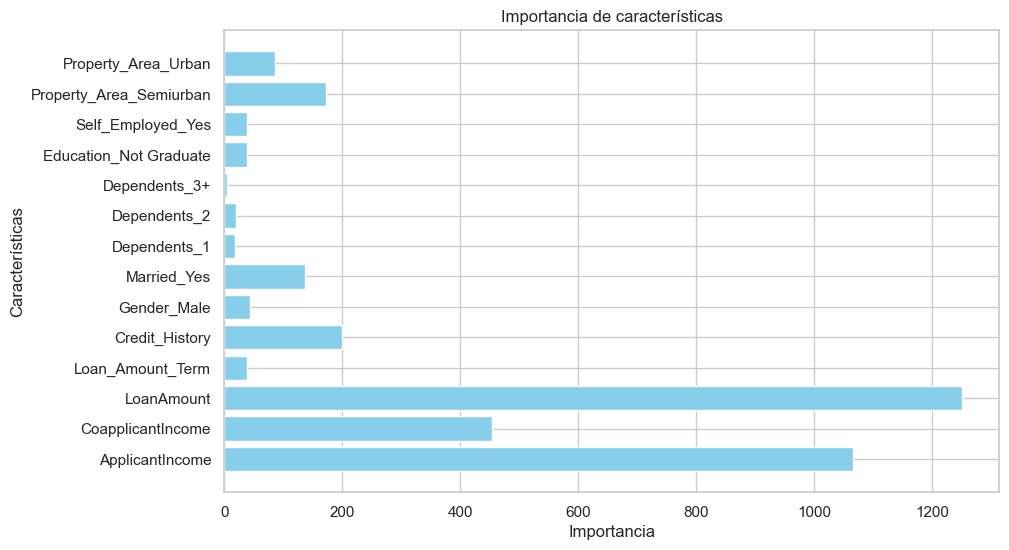

In [ ]:
# Transformación logarítmica para mitigar el impacto de outliers
for col in numerical_cols:
    df[col] = np.log1p(df[col])  # log1p(x) = log(1 + x)

# Codificación de variables categóricas con One-Hot Encoding
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
dataset_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Escalado de características numéricas
scaler = StandardScaler()
numerical_cols_transformed = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
dataset_encoded[numerical_cols_transformed] = scaler.fit_transform(dataset_encoded[numerical_cols_transformed])

# Dividir el conjunto de datos en entrenamiento y prueba
# Crear el dataset de entrenamiento y prueba
X = dataset_encoded.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = dataset_encoded['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)  # Convertir Loan_Status a binario

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo LightGBM básico
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Predicciones y evaluación inicial
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

print("Métricas del modelo inicial:")
print(f"Exactitud: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Optimización de hiperparámetros con GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

print("\nMétricas del modelo optimizado:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

# Visualización de importancia de características
feature_importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.title("Importancia de características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()